# Player Statistics Analysis

This notebook performs comprehensive analysis of player performance data, including:
- Basic statistics
- WOWY impact analysis
- Trend regression over stints
- Visualization of trends

Each section can be run independently.

In [115]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Define data directory
DATA_DIR = 'data/'

## Section 1: Load the datasets


In [116]:
# Load the datasets
player_data = pd.read_csv(DATA_DIR + 'player_data.csv')
stint_data = pd.read_csv(DATA_DIR + 'stint_data.csv')

# Add original order and sort by game_id and order
stint_data['original_order'] = range(len(stint_data))
stint_data = stint_data.sort_values(['game_id', 'original_order'])
stint_data['stint_number'] = stint_data.groupby('game_id').cumcount() + 1

# Function to extract team from player name
def extract_team(player):
    return '_'.join(player.split('_')[:-1])

# Prepare player data
player_data['team'] = player_data['player'].apply(extract_team)

# Compute game results
game_results = stint_data.groupby('game_id').agg({
    'h_goals': 'sum',
    'a_goals': 'sum',
    'h_team': 'first',
    'a_team': 'first'
}).reset_index()

# Initialize team stats
team_stats = defaultdict(lambda: {'wins': 0, 'draws': 0, 'losses': 0, 'points': 0, 'gd': 0})

for _, row in game_results.iterrows():
    h_team = row['h_team']
    a_team = row['a_team']
    h_goals = row['h_goals']
    a_goals = row['a_goals']
    gd = h_goals - a_goals
    
    if gd > 0:
        team_stats[h_team]['wins'] += 1
        team_stats[h_team]['points'] += 3
        team_stats[a_team]['losses'] += 1
    elif gd < 0:
        team_stats[a_team]['wins'] += 1
        team_stats[a_team]['points'] += 3
        team_stats[h_team]['losses'] += 1
    else:
        team_stats[h_team]['draws'] += 1
        team_stats[h_team]['points'] += 1
        team_stats[a_team]['draws'] += 1
        team_stats[a_team]['points'] += 1
    
    team_stats[h_team]['gd'] += gd
    team_stats[a_team]['gd'] -= gd

# Rank teams: first by points desc, then by gd desc
team_df = pd.DataFrame.from_dict(team_stats, orient='index')
team_df = team_df.sort_values(['points', 'gd'], ascending=[False, False])
team_rank = {team: rank+1 for rank, team in enumerate(team_df.index)}

print("Data loaded successfully")
print(f"Players: {len(player_data)}")
print(f"Stints: {len(stint_data)}")
print(f"Team ranks: {team_rank}")


Data loaded successfully
Players: 144
Stints: 7448
Team ranks: {'Japan': 1, 'USA': 2, 'France': 3, 'Great.Britain': 4, 'Canada': 5, 'Poland': 6, 'Brazil': 7, 'Denmark': 8, 'Columbia': 9, 'Chile': 10, 'Argentina': 11, 'Sweden': 12}


## Section 2: Expand stint data to individual player records

In [117]:
# Expected GD based on strength difference
expected_gd = (home_strength - away_strength) * 0.1  # factor 0.1


## Section 3: Compute stint goal differentials and number of stints

In [118]:
# Compute goal differentials for each player's stints
stint_gd_raw = defaultdict(lambda: defaultdict(list))
for _, row in expanded_df.iterrows():
    player = row['player']
    stint_num = row['player_stint_number']
    gd = row['normalized_gd']
    if stint_num <= 16:
        stint_gd_raw[player][stint_num].append(gd)

# Average the GDs for each stint number per player
stint_gd = {}
for player in stint_gd_raw:
    stint_gd[player] = {}
    for stint_num in stint_gd_raw[player]:
        stint_gd[player][stint_num] = np.mean(stint_gd_raw[player][stint_num])

# Compute max stint number per player
number_of_stints = {}
for player in stint_gd:
    number_of_stints[player] = max(stint_gd[player].keys()) if stint_gd[player] else 0

print("Normalized stint goal differentials computed")


Normalized stint goal differentials computed


## Section 4: Aggregate goals and minutes per player

In [119]:
# Aggregate goals and minutes per player
player_stats = expanded_df.groupby('player').agg({
    'goals_for': 'sum',
    'goals_against': 'sum',
    'minutes': 'sum'
}).reset_index()

# Calculate number of games per player
num_games_series = expanded_df.groupby('player')['game_id'].nunique()
player_stats['num_games'] = player_stats['player'].map(num_games_series)

# Calculate average minutes per game
player_stats['avg_minutes_per_game'] = player_stats['minutes'] / player_stats['num_games']

# Merge with player ratings
player_stats = player_stats.merge(player_data[['player', 'rating']], on='player', how='left')

# Calculate plus/minus per minute
player_stats['plus_minus_per_min'] = (player_stats['goals_for'] - player_stats['goals_against']) / player_stats['minutes']

print("Basic player statistics calculated")

Basic player statistics calculated


## Section 5: Calculate WOWY impact

In [120]:
# Initialize stats dictionaries
with_stats = defaultdict(lambda: defaultdict(lambda: {'gf': 0, 'ga': 0, 'min': 0}))
total_stats = defaultdict(lambda: {'gf': 0, 'ga': 0, 'min': 0})

# First, compute total stats for each player
for _, row in stint_data.iterrows():
    h_team = row['h_team']
    a_team = row['a_team']
    h_gf = row['h_goals']
    h_ga = row['a_goals']
    a_gf = row['a_goals']
    a_ga = row['h_goals']
    minutes = row['minutes']
    
    lineup_h = [row[f'home{i}'] for i in range(1, 5)]
    lineup_a = [row[f'away{i}'] for i in range(1, 5)]
    
    for player in lineup_h:
        total_stats[player]['gf'] += h_gf
        total_stats[player]['ga'] += h_ga
        total_stats[player]['min'] += minutes
    
    for player in lineup_a:
        total_stats[player]['gf'] += a_gf
        total_stats[player]['ga'] += a_ga
        total_stats[player]['min'] += minutes

# Compute with_stats for each pair
for _, row in stint_data.iterrows():
    h_team = row['h_team']
    a_team = row['a_team']
    h_gf = row['h_goals']
    h_ga = row['a_goals']
    a_gf = row['a_goals']
    a_ga = row['h_goals']
    minutes = row['minutes']
    
    lineup_h = [row[f'home{i}'] for i in range(1, 5)]
    lineup_a = [row[f'away{i}'] for i in range(1, 5)]
    
    for i in lineup_h:
        for j in lineup_h:
            if i != j:
                with_stats[i][j]['gf'] += h_gf
                with_stats[i][j]['ga'] += h_ga
                with_stats[i][j]['min'] += minutes
    
    for i in lineup_a:
        for j in lineup_a:
            if i != j:
                with_stats[i][j]['gf'] += a_gf
                with_stats[i][j]['ga'] += a_ga
                with_stats[i][j]['min'] += minutes

# Compute without_stats as total - with
without_stats = defaultdict(lambda: defaultdict(lambda: {'gf': 0, 'ga': 0, 'min': 0}))
for i in player_data['player']:
    for j in player_data['player']:
        if i != j and player_data[player_data['player'] == i]['team'].iloc[0] == player_data[player_data['player'] == j]['team'].iloc[0]:
            without_stats[i][j]['gf'] = total_stats[j]['gf'] - with_stats[i][j]['gf']
            without_stats[i][j]['ga'] = total_stats[j]['ga'] - with_stats[i][j]['ga']
            without_stats[i][j]['min'] = total_stats[j]['min'] - with_stats[i][j]['min']

# Compute WOWY for each player
wowy_dict = {}
for i in player_data['player']:
    team_i = player_data[player_data['player'] == i]['team'].iloc[0]
    teammates = [j for j in player_data['player'] if player_data[player_data['player'] == j]['team'].iloc[0] == team_i and j != i]
    
    deltas = []
    weights = []
    for j in teammates:
        gf_with = with_stats[i][j]['gf']
        ga_with = with_stats[i][j]['ga']
        gf_without = without_stats[i][j]['gf']
        ga_without = without_stats[i][j]['ga']
        min_with = with_stats[i][j]['min']
        
        if gf_with + ga_with > 0:
            gf_pct_with = gf_with / (gf_with + ga_with)
        else:
            gf_pct_with = 0
        
        if gf_without + ga_without > 0:
            gf_pct_without = gf_without / (gf_without + ga_without)
        else:
            gf_pct_without = 0
        
        delta = gf_pct_with - gf_pct_without
        weight = min_with  # weight by shared minutes
        
        if min_with > 0:  # only if they played together
            deltas.append(delta)
            weights.append(weight)
    
    if weights:
        wowy = sum(d * w for d, w in zip(deltas, weights)) / sum(weights)
    else:
        wowy = 0
    
    wowy_dict[i] = wowy

# Add WOWY to player_stats
player_stats['wowy'] = player_stats['player'].map(wowy_dict)

print("WOWY impact calculated")

WOWY impact calculated


## Section 6: Add all stats to player_data

In [121]:
# Add stint data to player_data
player_data['number_of_stints'] = player_data['player'].map(number_of_stints).fillna(0)
for i in range(1, 17):
    player_data[f'stint{i}_gd'] = player_data['player'].map(lambda p: stint_gd[p].get(i, None))

# Add trend columns
player_data['trend_slope'] = player_data['player'].map(lambda p: trend_dict[p]['slope'])
player_data['trend_intercept'] = player_data['player'].map(lambda p: trend_dict[p]['intercept'])

# Add player_stats columns to player_data
missing_cols = [col for col in ['plus_minus_per_min', 'avg_minutes_per_game', 'wowy'] if col not in player_data.columns]
if missing_cols:
    player_data = player_data.merge(player_stats[['player'] + missing_cols], on='player', how='left')

# Remove any duplicate columns with .1 suffix
player_data = player_data.loc[:, ~player_data.columns.str.contains(r'\.1$')]

# Remove trend slope and intercept columns
player_data = player_data.drop(columns=['trend_slope', 'trend_intercept'], errors='ignore')

print(f"Final player_data shape: {player_data.shape}")
print("All statistics added to player_data")

Final player_data shape: (144, 23)
All statistics added to player_data


## Section 7: Plot trend lines for Canadian & Japanese players

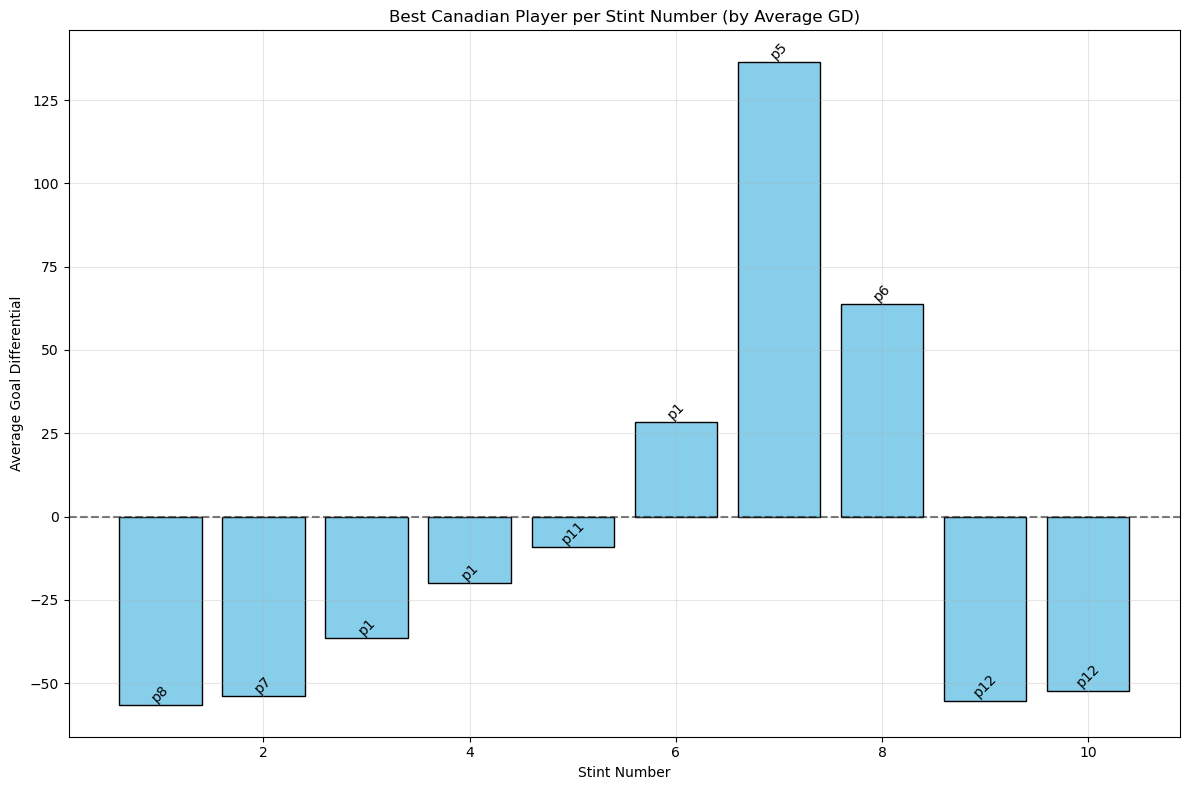

Best player per stint plot displayed in notebook


In [ ]:
# Plot best Canadian player per stint number
canada_players = player_data[player_data['team'] == 'Canada']

# Collect data for best player per stint
stint_nums = sorted(set().union(*[stint_gd[player].keys() for player in canada_players['player']]))
best_players = {}
best_gds = {}

for stint in stint_nums:
    stint_data = {player: stint_gd[player].get(stint, float('-inf')) for player in canada_players['player']}
    best_player = max(stint_data, key=stint_data.get)
    best_gd = stint_data[best_player]
    if best_gd != float('-inf'):
        best_players[stint] = best_player
        best_gds[stint] = best_gd

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(best_players.keys(), best_gds.values(), color='skyblue', edgecolor='black')

# Add player names on bars
for bar, stint in zip(bars, best_players.keys()):
    player_name = best_players[stint].split('_')[-1]  # Get last part of name for brevity
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, player_name, 
            ha='center', va='bottom', fontsize=10, rotation=45)

ax.set_xlabel('Stint Number')
ax.set_ylabel('Normalized Average Goal Differential')
ax.set_title('Best Canadian Player per Stint Number (by Average GD)')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Best player per stint plot displayed in notebook")

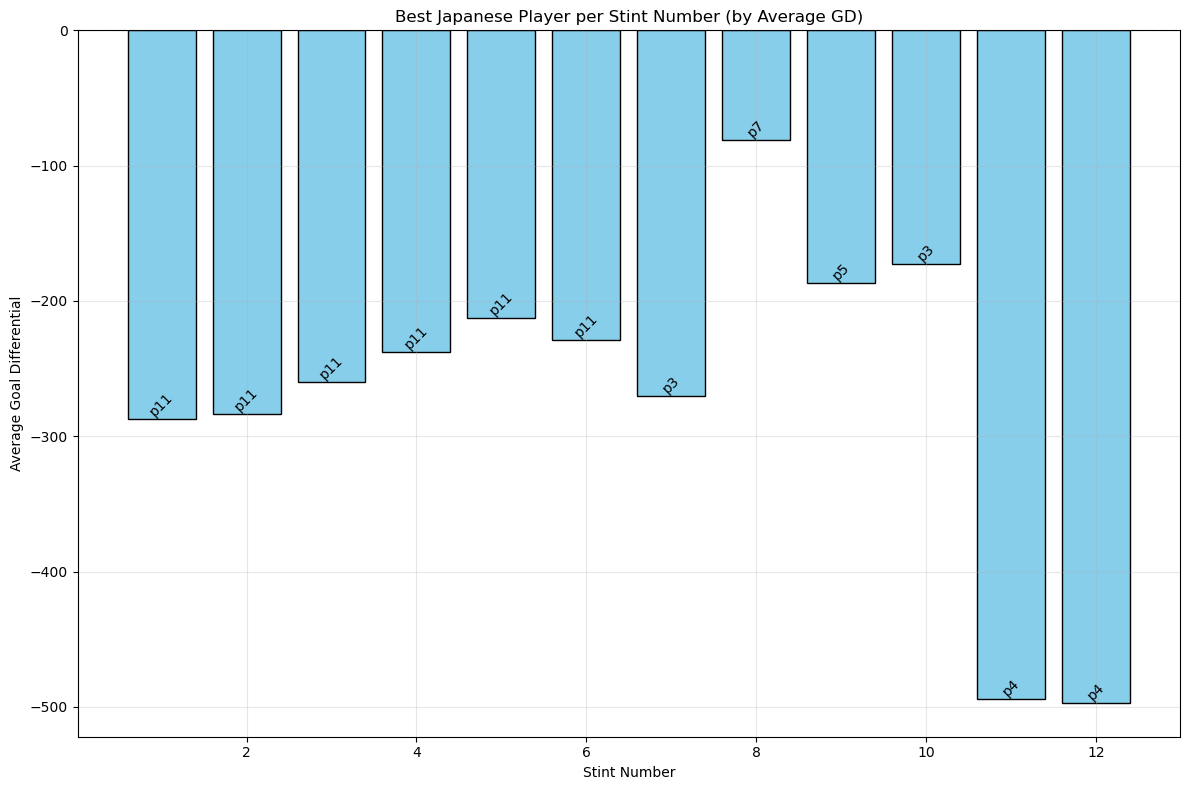

Best player per stint plot displayed in notebook


In [ ]:
# Plot best Japanese player per stint number
japan_players = player_data[player_data['team'] == 'Japan']

# Collect data for best player per stint
stint_nums = sorted(set().union(*[stint_gd[player].keys() for player in japan_players['player']]))
best_players = {}
best_gds = {}

for stint in stint_nums:
    stint_data = {player: stint_gd[player].get(stint, float('-inf')) for player in japan_players['player']}
    best_player = max(stint_data, key=stint_data.get)
    best_gd = stint_data[best_player]
    if best_gd != float('-inf'):
        best_players[stint] = best_player
        best_gds[stint] = best_gd

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(best_players.keys(), best_gds.values(), color='skyblue', edgecolor='black')

# Add player names on bars
for bar, stint in zip(bars, best_players.keys()):
    player_name = best_players[stint].split('_')[-1]  # Get last part of name for brevity
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, player_name, 
            ha='center', va='bottom', fontsize=10, rotation=45)

ax.set_xlabel('Stint Number')
ax.set_ylabel('Normalized Average Goal Differential')
ax.set_title('Best Japanese Player per Stint Number (by Average GD)')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Best player per stint plot displayed in notebook")

## Section 8: Save updated player_data

In [124]:
# Save updated player_data
player_data.to_csv(DATA_DIR + 'player_data.csv', index=False)

print("Updated player_data.csv saved with all statistics")

Updated player_data.csv saved with all statistics
